In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [2]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
cloud_config= {'secure_connect_bundle': 'F:\INTERNSHIP\MS\secure-connect-mushroomclassificationapp.zip'
}
auth_provider = PlainTextAuthProvider('osAwvxWvfldbJyZbsKWdvdUy', '6vhSlvZokW-peh9_Uin.ttf.6i-JegRYrnst138YLlwIZuZ99qfYjA9cai6laL.ZoO6K5tUPJ3tHv1vr.q7ZkNH8UMTb6oyLe2IkkbI75mxhfHgCsPL1rJ.,5wXZUjkT')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)

session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
    print(row[0])
else:
    print("An error occurred.")

4.0.0.6816


In [3]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

session.row_factory = pandas_factory
session.default_fetch_size = None

query = "SELECT * FROM mca.mushrooms"
rslt = session.execute(query, timeout=None)
data = rslt._current_rows

In [4]:
#data=pd.read_csv('mushrooms.csv')

In [5]:
#data.head()

In [6]:
data.shape

(8124, 23)

# Mushroom Structure
<img src="g.jpg" width="240" height="240" align="center"/>

# Attribute Information: 
## classes: 
- edible=e, poisonous=p

# 1. CAP

   **cap-shape** :bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s

   **cap-surface**  : fibrous=f, grooves=g, scaly=y, smooth=s

   **cap-color** : brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y

# 2. BRUISES

   **bruises** : bruises=t, no=f


# 3. ODOR

   **odor** :almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s


# 4. GILL

   **gill-attachment** : attached=a, descending=d, free=f, notched=n

   **gill-spacing** : close=c, crowded=w, distant=d

   **gill-size** : broad=b, narrow=n

   **gill-color** : black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y

# 5. STALK

   **stalk-shape** : enlarging=e, tapering=t

   **stalk-root** : bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
   
   **stalk-surface-above-ring** : fibrous=f, scaly=y, silky=k, smooth=s

   **stalk-surface-below-ring** : fibrous=f, scaly=y, silky=k, smooth=s

   **stalk-color-above-ring** : brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
   
   **stalk-color-below-ring** : brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y

# 6. Veil

   **veil-type** : partial=p, universal=u

   **veil-color** : brown=n, orange=o, white=w, yellow=y


# 7. Ring

   **ring-number** : none=n, one=o, two=t
    
   **ring-type** : cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z

# 8. SPORE

   **spore-print-color** : black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y

# 9. POPULATION

   **population** : abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y

# 10. HABITAT

   **habitat** : grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

# EDA

In [7]:
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

# Data Analysis

In [9]:
data['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

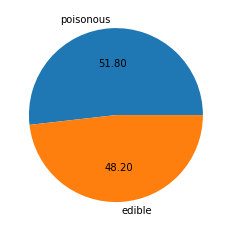

In [10]:
#1 is p and 0 is E
plt.pie(data['class'].value_counts(), labels=['poisonous','edible'],autopct="%0.2f")
plt.show()

**if mushroom has odor almond, anise and none then you can eat**

In [11]:
def CPlot(CN):
    sns.histplot(data=data, x=CN, hue="class", multiple="dodge")
    plt.xlabel(CN,fontsize=15)
    plt.ylabel('mushroom poisonous',fontsize=15)
    plt.show()

# bruises

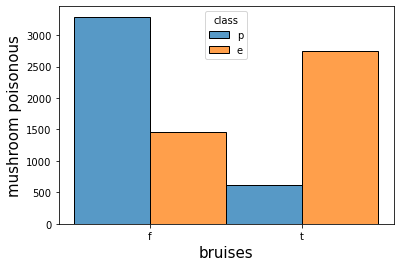

In [12]:
CPlot(data.columns[4])

# Cap Shape

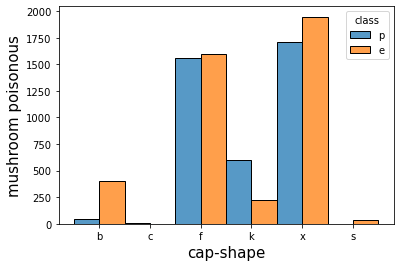

In [13]:
CPlot(data.columns[1])

# cap-surface

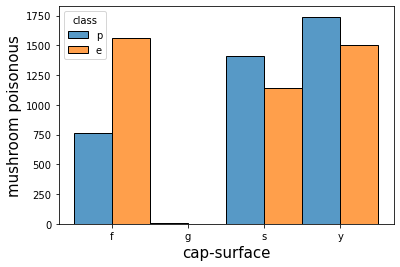

In [14]:
CPlot(data.columns[2])

# cap-color

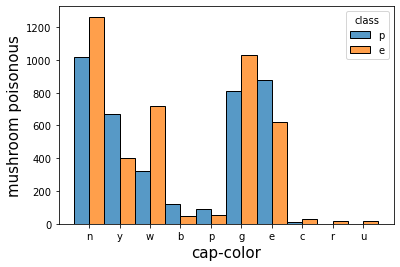

In [15]:
CPlot(data.columns[3])

# Odor

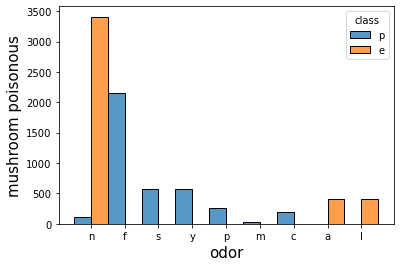

In [16]:
CPlot(data.columns[5])

# gill-attachment

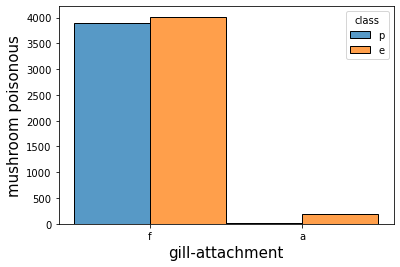

In [17]:
CPlot(data.columns[6])

# gill-spacing

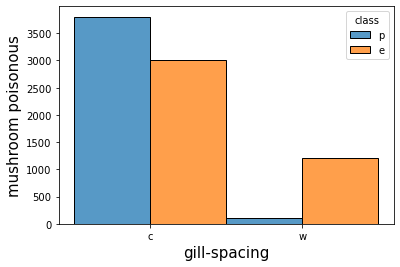

In [18]:
CPlot(data.columns[7])

# gill-size

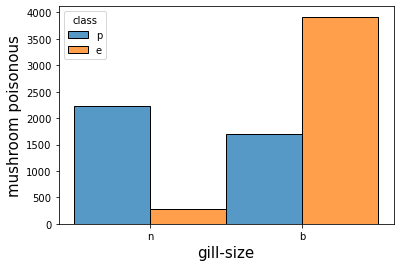

In [19]:
CPlot(data.columns[8])

# gill-color

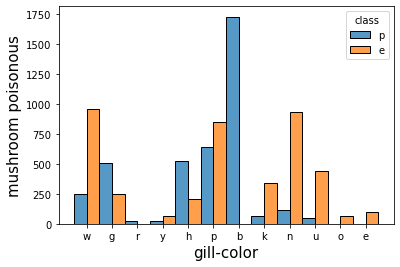

In [20]:
CPlot(data.columns[9])

# Habitat

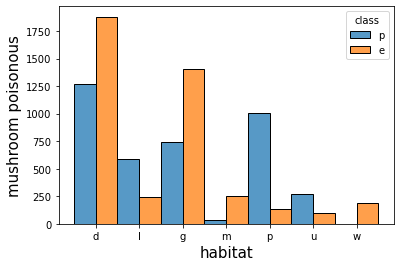

In [21]:
CPlot(data.columns[22])

# Stalk shape

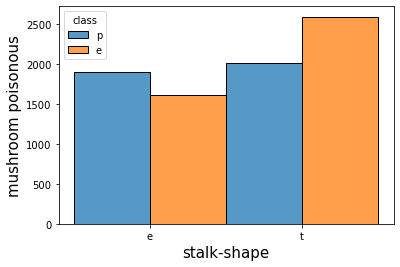

In [22]:
CPlot(data.columns[10])

# Stalk-Root

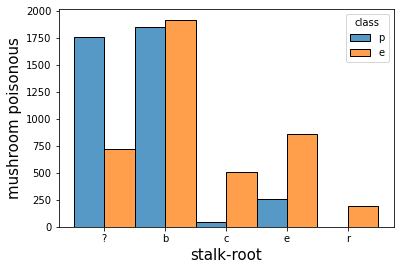

In [23]:
CPlot(data.columns[11])

# Stalk-Surface-Above-ring

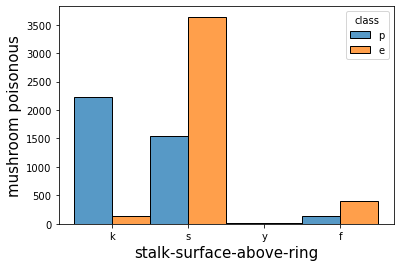

In [24]:
CPlot(data.columns[12])

# Stalk-Surface-below-ring

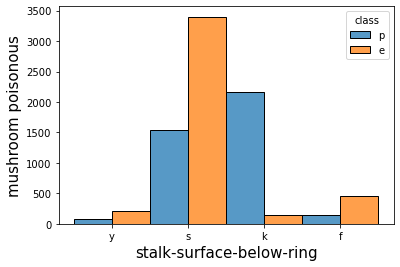

In [25]:
CPlot(data.columns[13])

# Stalk-color-above-ring

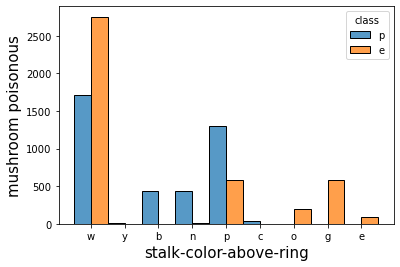

In [26]:
CPlot(data.columns[14])

# Stalk-color-below-ring

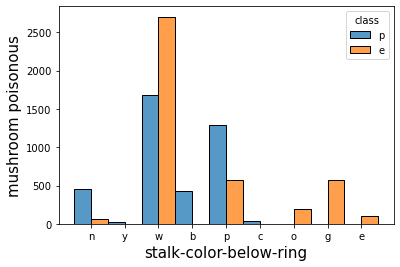

In [27]:
CPlot(data.columns[15])

# Veil type

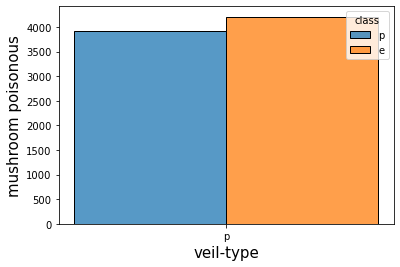

In [28]:
CPlot(data.columns[16])

# Veil-color

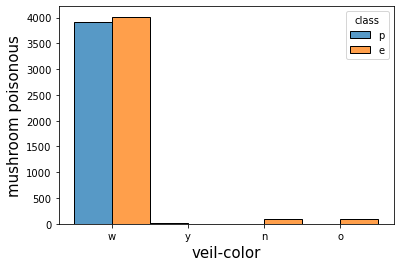

In [29]:
CPlot(data.columns[17])

# Ring Number

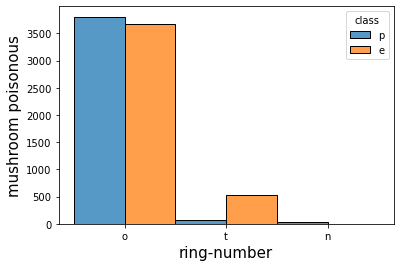

In [30]:
CPlot(data.columns[18])

# Ring type

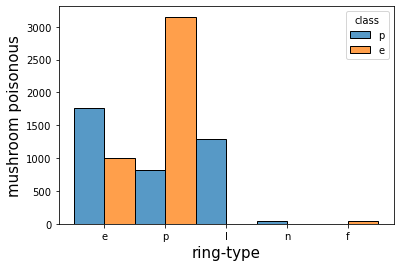

In [31]:
CPlot(data.columns[19])

# Spore-print-color

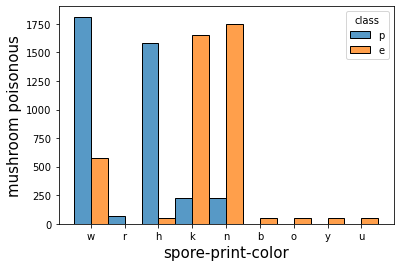

In [32]:
CPlot(data.columns[20])

# Population

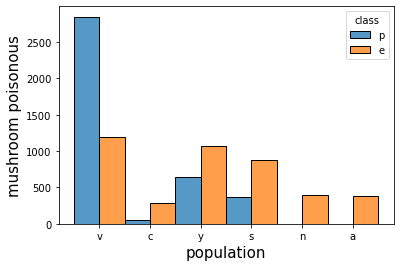

In [33]:
CPlot(data.columns[21])

# Label Encoding

In [34]:
Le=LabelEncoder()
data['class']=Le.fit_transform(data['class'])

# Data Selection

In [35]:
colX=['cap-color',  'bruises', 'odor', 
          'gill-color', 'stalk-shape', 'veil-color',
          'ring-type', 'spore-print-color', 'population', 'habitat'
        ]

In [36]:
X=data.loc[:,colX]
Y=data.iloc[:,0]

In [37]:
X.shape

(8124, 10)

In [38]:
X.head()

,cap-color,bruises,odor,gill-color,stalk-shape,veil-color,ring-type,spore-print-color,population,habitat
0,n,f,n,w,e,w,e,w,v,d
1,n,f,n,w,e,w,e,w,v,d
2,y,f,n,w,e,w,e,w,v,d
3,y,f,n,w,e,w,e,w,v,d
4,w,t,n,w,e,w,p,w,c,l


In [39]:
Y.shape

(8124,)

# Split

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

# Using Col Transformers

### Step 1: Ordinal encoding

In [41]:
trf1 = ColumnTransformer([
         ("ordinal", OrdinalEncoder(), 
         ['cap-color','bruises','odor',
          'gill-color', 'stalk-shape', 'veil-color',
          'ring-type','spore-print-color', 'population', 'habitat'
        ] )
    ],remainder='passthrough')

### Step 2 : Feature selection Using SelectKBest

In [42]:
trf2 = SelectKBest(score_func=chi2,k=8)

### Step 3: Model Training

In [43]:
trf3 = RandomForestClassifier()
#trf3 = GaussianNB()
#trf3 = MultinomialNB()
#trf3 = BernoulliNB()
#trf3=LogisticRegression()
#trf3=SVC()

In [44]:
# Display Pipeline
from sklearn import set_config
set_config(display='diagram')

# Creating Pipe

In [45]:
pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ('trf3',trf3),
])

In [46]:
# train
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['cap-color', 'bruises',
                                                   'odor', 'gill-color',
                                                   'stalk-shape', 'veil-color',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('trf2',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x000001F09098AC10>)),
                ('trf3', RandomForestClassifier())])

# Pipe analysis

In [47]:
cols = pipe.named_steps.trf2.get_support(indices=True)

In [48]:
new_features = X_train.columns[cols]

In [49]:
new_features

Index(['bruises', 'odor', 'gill-color', 'stalk-shape', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [50]:
FIN=pipe.named_steps.trf3.feature_importances_

# Feature Importance

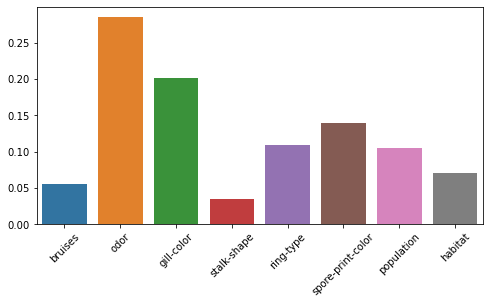

In [51]:
plt.figure(figsize = (8,4))
ax = sns.barplot(x = new_features, y =FIN)
plt.xticks(rotation=45)
plt.show()

# Prediction

In [52]:
prediction = pipe.predict(X_test)

In [53]:
prediction

array([0, 0, 0, ..., 0, 0, 1])

# Accuracy

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,prediction)

1.0

# Precision recall

In [55]:
from sklearn.metrics import precision_score,recall_score, confusion_matrix, classification_report,accuracy_score, f1_score
print('Accuracy:', accuracy_score(y_test, prediction))
print('F1 score:', f1_score(y_test, prediction))
print('Recall:', recall_score(y_test, prediction))
print('Precision:', precision_score(y_test, prediction))
print('\n clasification report:\n', classification_report(y_test,prediction))
print('\n confussion matrix:\n',confusion_matrix(y_test, prediction))

Accuracy: 1.0
F1 score: 1.0
Recall: 1.0
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


 confussion matrix:
 [[843   0]
 [  0 782]]


# Cross Validation using Pipeline

In [56]:
# cross validation using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

1.0

# Exporting the Pipeline

In [59]:
#Match this Output with Predict.ipynb for Happiness
pipe.predict(X_train[0:1])

array([0])

In [60]:
# export 
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

# Custom Prediction

In [57]:
j=X_train.iloc[0,:]

In [58]:
#I am going to use this value as a custom data in prediction
j.values.tolist()

['w', 'f', 'n', 'p', 'e', 'w', 'p', 'w', 's', 'g']

# Printing List for app.py

In [61]:
def findCL(Col_Name):
    Col_Name=X_train[Col_Name].value_counts().index.tolist()
    print(Col_Name)

In [62]:
LOL=X_train.columns.tolist()

In [63]:
LOL

['cap-color',
 'bruises',
 'odor',
 'gill-color',
 'stalk-shape',
 'veil-color',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [64]:
for i in LOL:
    print(i + ' :')
    findCL(i)

cap-color :
['n', 'g', 'e', 'y', 'w', 'b', 'p', 'c', 'r', 'u']
bruises :
['f', 't']
odor :
['n', 'f', 'y', 's', 'l', 'a', 'p', 'c', 'm']
gill-color :
['b', 'p', 'w', 'n', 'g', 'h', 'u', 'k', 'e', 'y', 'o', 'r']
stalk-shape :
['t', 'e']
veil-color :
['w', 'n', 'o', 'y']
ring-type :
['p', 'e', 'l', 'f', 'n']
spore-print-color :
['w', 'n', 'k', 'h', 'r', 'o', 'u', 'b', 'y']
population :
['v', 'y', 's', 'n', 'a', 'c']
habitat :
['d', 'g', 'p', 'l', 'u', 'm', 'w']
